# Project 2
Group members: Lena Jörg, Sigurd Kolltveit, Gregor Moe

In [86]:
#import numpy as np
import autograd.numpy as np  # required for automatic differentiation
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Model system 3.1 - 2D charged particle

In [87]:
def B_particle(x):
    x1 = x[0]
    x2 = x[1]
    return np.array([0,0,np.sqrt(x1**2+x2**2)])

def A_particle(x):
    x1 = x[0]
    x2 = x[1]
    return np.array([-x2*np.sqrt(x1**2+x2**2), x1*np.sqrt(x1**2+x2**2), 0])/3

def U_particle(x):
    x1 = x[0]
    x2 = x[1]
    return 1/(100*np.sqrt(x1**2 + x2**2))

def gradU_particle(x):
    x1 = x[0]
    x2 = x[1]
    u0 = x1/((x1**2 + x2**2)**(3/2))
    u1 = x2/((x1**2 + x2**2)**(3/2))
    return np.array([u0,u1,0])/(-100)

x0_particle = np.array([0.0, 1.0, 0.1], dtype=float)
v0_particle = np.array([0.09, 0.05, 0.20], dtype=float) 

Model system 3.2 - Tokamak magnetic field

In [88]:
def B_tokamak(x):
    x1,x2,x3 = x
    b1 = -(2*x1 + x1*x3)/(2*(x1**2+x2**2))
    b2 = (2*x1 - x2*x3)/(2*(x1**2+x2**2))
    b3 = (np.sqrt(x1**2 + x2**2) - 1)/(2*np.sqrt(x1**2+x2**2))
    return np.array([b1, b2, b3])

def A_tokamak(x):
    x1,x2,x3 = x
    a2 = (x1 - np.log(np.sqrt(x1**2 + x2**2) + x1))/2
    a3 = (x3*np.arctan2(x2, x1) + np.log(x1**2 + x2**2))/(-2)
    return np.array([0, a2, a3])

def U_tokamak(x):
    return 0

def gradU_tokamak(x):
    return np.array([0, 0, 0])

x0_tokamak = np.array([1.2, 0, 0], dtype=float)
v0_tokamak = np.array([0, 4.816e-4, -2.059e-3], dtype=float)

### Boris method implementation

In [89]:
def boris_step(x, v_half, h, B, gradU):
    v_minus = v_half - 0.5 * h * gradU(x)

    t = 0.5 * h * B(x)
    t_mag2 = np.dot(t, t)

    v_prime = v_minus + np.cross(v_minus, t)
    s = 2 * t / (1 + t_mag2)

    v_plus = v_minus + np.cross(v_prime, s)
    v_half_next = v_plus - 0.5 * h * gradU(x)

    x_next = x + h * v_half_next
    return x_next, v_half_next


def initialize_v_half(x0, v0, h, B, gradU):
    def rhs(t, y):
        x, v = y[:3], y[3:]
        return np.concatenate([v, np.cross(v, B(x)) - gradU(x)])
    
    sol = solve_ivp(rhs, [0, -h/2], np.concatenate([x0, v0]), rtol=1e-10, atol=1e-12)
    return sol.y[3:, -1]


def boris_integrate(x0, v0, T, h, B, gradU):
    N = int(T/h)
    x = np.zeros((N, 3))
    v_half = np.zeros((N, 3))

    x[0] = x0
    v_half[0] = initialize_v_half(x0, v0, h, B, gradU)

    for n in range(N-1):
        x[n+1], v_half[n+1] = boris_step(x[n], v_half[n], h, B, gradU)

    return x, v_half

# Convert half-step velocities to integer-step velocities
def v_integer(v_half):
    return 0.5 * (v_half[:-1] + v_half[1:])

### Runge-Kutta 4 implementation

In [90]:
def rk4_step(x_prev,v_prev,h,f):
    kx1 = h*v_prev
    kv1 = h*f(x_prev,v_prev)

    kx2 = h*(v_prev + kv1/2)
    kv2 = h*f(x_prev + kx1/2, v_prev + kv1/2)

    kx3 = h*(v_prev + kv2/2)
    kv3 = h*f(x_prev + kx2/2, v_prev + kv2/2)

    kx4 = h*(v_prev + kv3)
    kv4 = h*f(x_prev + kx3, v_prev + kv3)

    v = v_prev + (kv1 + 2*kv2 + 2*kv3 + kv4)/6
    x = x_prev + (kx1 + 2*kx2 + 2*kx3 + kx4)/6
    return x, v

def rk4(Tmax,h, x0, v0, B_func, A_func, U_func, gradU_func):
    maxiter = int(Tmax/h)

    xs = np.zeros((maxiter,3))
    vs = np.zeros((maxiter,3))
    xs[0] = x0
    vs[0] = v0
    f = lambda x,v: np.cross(v,B_func(x)) - gradU_func(x)
    
    i = 1 
    while i<maxiter: #regner denne iterasjonen
        xs[i], vs[i] = rk4_step(xs[i-1],vs[i-1],h,f)
        i += 1
    return xs, vs

### Fourth-order symmetric multistep method implementation

In [91]:
from scipy.integrate import solve_ivp


# uses solve_ivp to get the initial n points of the solution
def initial_soln(x0, v0, B, gradU, h, Tmax):
    n = int(Tmax / h)
    def rhs(t, y):
        x, v = y[:3], y[3:]
        return np.concatenate([v, np.cross(v, B(x)) - gradU(x)])

    ts = [k * h for k in range(n)] # we only want the soln at these points
    res = solve_ivp(rhs, (0, h*n), [*x0, *v0], t_eval=ts, rtol=1e-10, atol=1e-12)
    x = res.y[:3].transpose()
    v = res.y[3:].transpose()
    return x, v



In [92]:
from autograd import jacobian


A_particle_jacobian = jacobian(A_particle)
A_tokamak_jacobian = jacobian(A_tokamak)


# calculates the five-point central difference of the array y at j
def Δ(y, j, f=lambda x: x):
    return (1/12) * (f(y[j-2]) - 8*f(y[j-1]) + 8*f(y[j+1]) - f(y[j+2]))


def fourth_order_multistep(x0, v0, B, A, A_diff, gradU, h, Tmax):
    n = int(Tmax / h)
    def F(j, x, v):
        v[j] = Δ(x, j)/h
        A_delta_j = Δ(x, j, A)/h

        return A_diff(x[j]).mT @ v[j] - A_delta_j - gradU(x[j])


    a1, a2, a3 = -0.7, 0.1, 0.9
    beta0 = (1/3) * (20*a1*a2*a3 - 4*(a1*a2 + a1*a3 + a2*a3) - 28*(a1 + a2 + a3) - 52)
    beta1 = (1/3) * (2*a1*a2*a3 + 14*(a1*a2 + a1*a3 + a2*a3) + 26*(a1 + a2 + a3) + 38)
    alpha = (1, -7/5, 9/25, 22/125, -34/125, 22/125, 9/25, -7/5, 1)

    x, v = initial_soln(x0, v0, B, gradU, h, 8 * h) # get initial 8 points

    # pad with zeroes on the right
    x = np.pad(x, ((0, n-8), (0, 0)))
    v = np.pad(v, ((0, n-8), (0, 0)))
    assert v.shape == x.shape == (n, 3)

    for n in range(4, n-4):
        other_xs = np.dot(alpha[:-1], x[n-4:n+4])  # j = 4 is omitted from this sum
        Fn = F(n, x, v)
        Fnplus1 = F(n+1, x, v)
        Fnmin1 = F(n-1, x, v)
        x[n+4] = h**2 * (beta1 * Fnmin1 + beta0*Fn + beta1*Fnplus1) - other_xs
    
    return x, v



## Trajectory plots

In [93]:
Tmax = 1000
h = 0.1


def plot_trajectory(x, system, method):
    plt.figure(figsize=(6,6))
    plt.plot(x[:,0], x[:,1])
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.title(f"Trajectory in (x₁, x₂) for {system} ({method})")
    plt.axis("equal")
    plt.grid(True)
    plt.show()


def tokamak_banana_orbit(x, method):
    R = np.sqrt(x[:,0]**2 + x[:,1]**2)
    plt.figure(figsize=(6,6))
    plt.plot(R, x[:,2])
    plt.xlabel("R = sqrt(x₁² + x₂²)")
    plt.ylabel("x₃")
    plt.title(f"Banana Orbit (Tokamak Field, {method})")
    plt.grid(True)
    plt.show()

#### Boris method

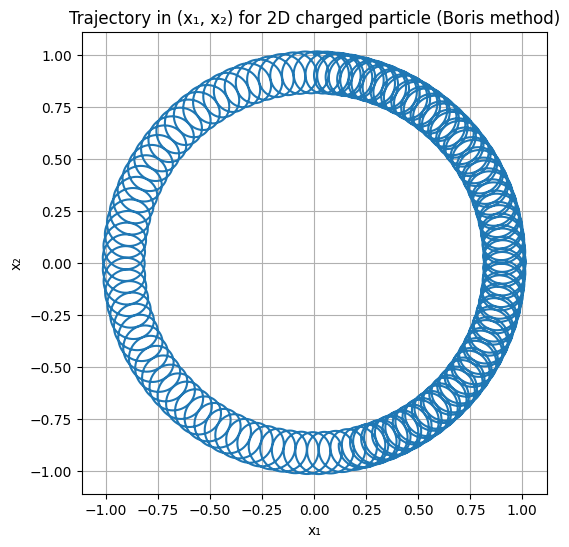

In [94]:
boris_x_2D, v_half_2D = boris_integrate(x0_particle, v0_particle, Tmax, h, B_particle, gradU_particle)
boris_v_2D = np.pad(v_integer(v_half_2D), ((0, 1), (0, 0)), mode="edge")

plot_trajectory(boris_x_2D, "2D charged particle", "Boris method")

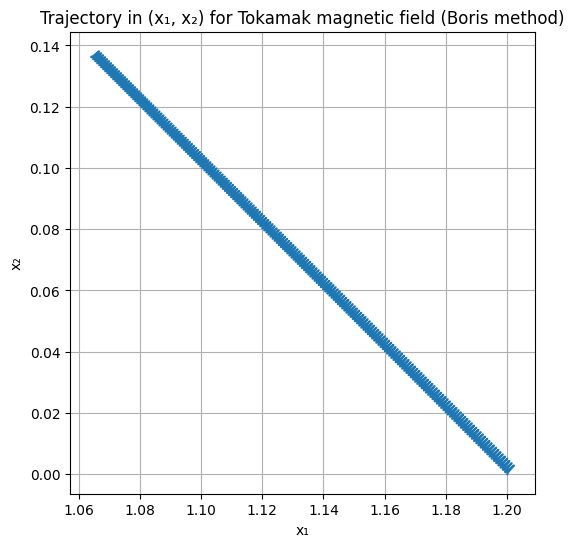

In [95]:
boris_x_tok, v_half_tok = boris_integrate(x0_tokamak, v0_tokamak, Tmax, h, B_tokamak, gradU_tokamak)
boris_v_tok = np.pad(v_integer(v_half_tok), ((0, 1), (0, 0)), mode="edge")

plot_trajectory(boris_x_tok, "Tokamak magnetic field", "Boris method")

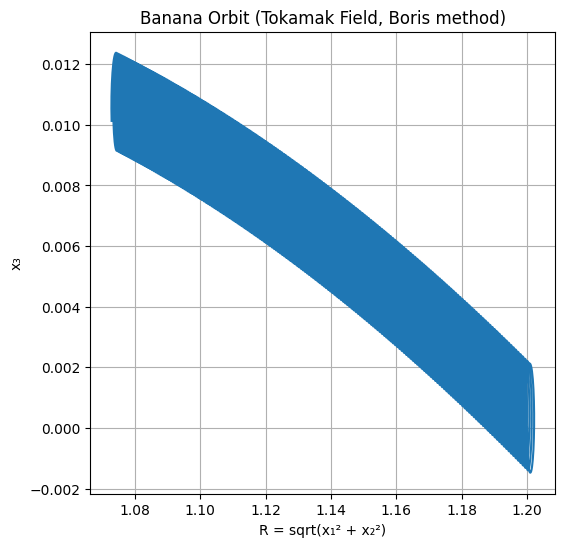

In [96]:
tokamak_banana_orbit(boris_x_tok, "Boris method")

#### Runge-Kutta 4

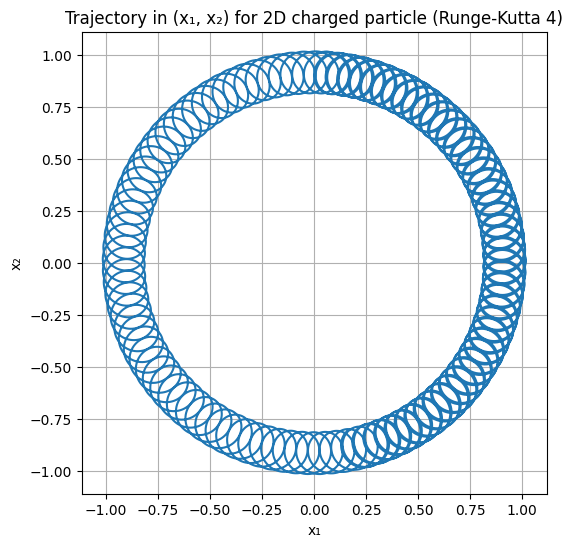

In [97]:

rk4_x_2D, rk4_v_2D = rk4(Tmax, h, x0_particle, v0_particle, B_particle, A_particle, U_particle, gradU_particle)

plot_trajectory(rk4_x_2D, "2D charged particle", "Runge-Kutta 4")

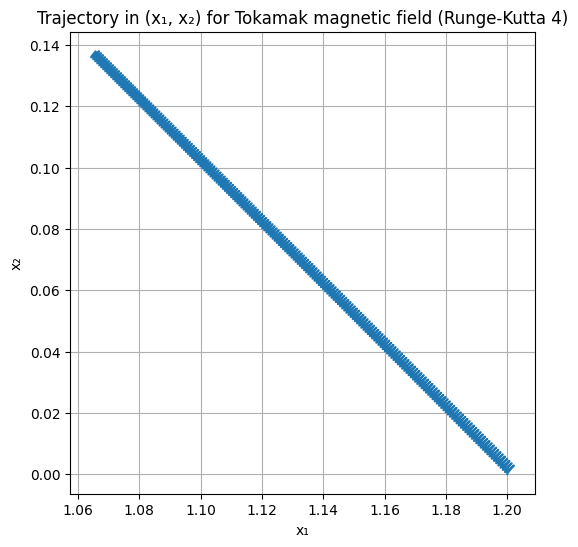

In [98]:
rk4_x_tok, rk4_v_tok = rk4(Tmax, h, x0_tokamak, v0_tokamak, B_tokamak, A_tokamak, U_tokamak, gradU_tokamak)

plot_trajectory(rk4_x_tok, "Tokamak magnetic field", "Runge-Kutta 4")

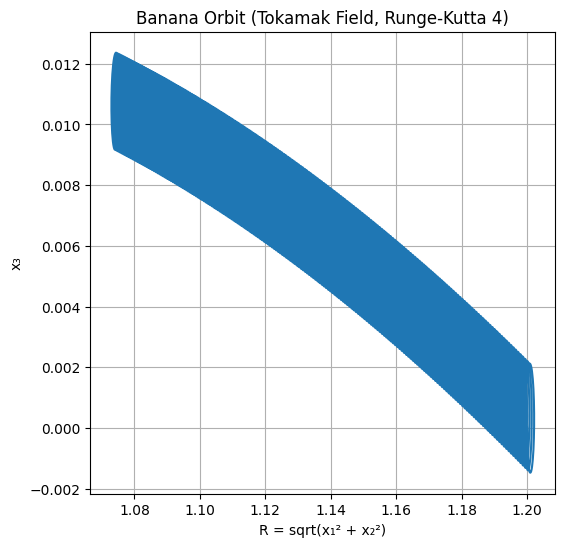

In [99]:
tokamak_banana_orbit(rk4_x_tok, "Runge-Kutta 4")

#### Fourth-order symmetric multistep method

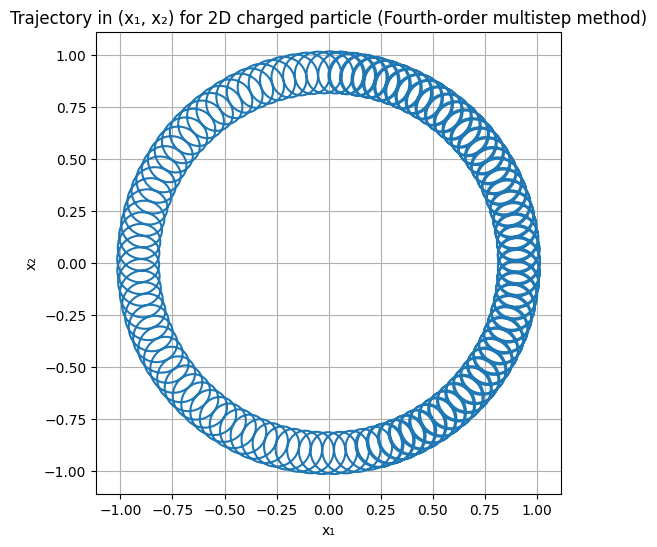

In [100]:
multistep_x_2D, multistep_v_2D = fourth_order_multistep(x0_particle, v0_particle, B_particle, A_particle, A_particle_jacobian, gradU_particle, h, Tmax)

plot_trajectory(multistep_x_2D, "2D charged particle", "Fourth-order multistep method")

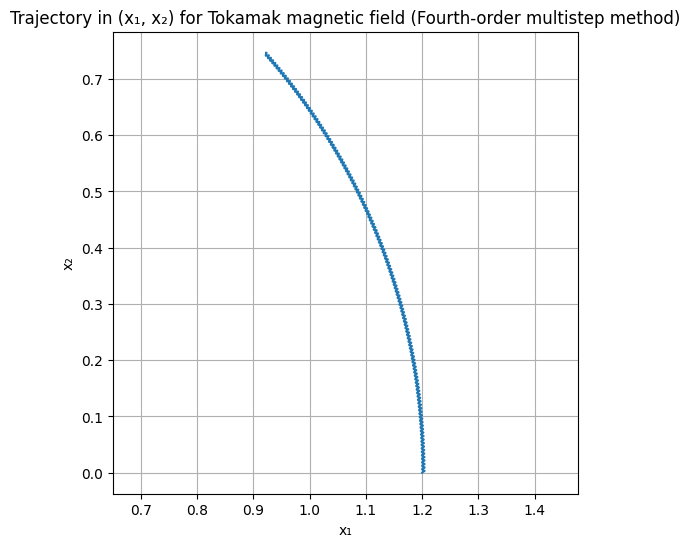

In [101]:
multistep_x_tok, multistep_v_tok = fourth_order_multistep(x0_tokamak, v0_tokamak, B_tokamak, A_tokamak, A_tokamak_jacobian, gradU_tokamak, h, Tmax)

plot_trajectory(multistep_x_tok, "Tokamak magnetic field", "Fourth-order multistep method")

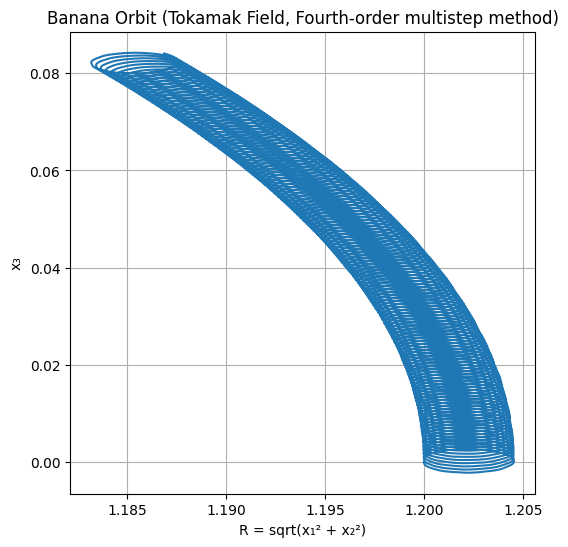

In [102]:
tokamak_banana_orbit(multistep_x_tok, "Fourth-order multistep method")

Note that for the fourth-order multistep method, the tokamak magnetic field trajectory differs slightly from the other two methods, and also from the reference solution, as shown in the error plots below. This might be because as mentioned in Hairer and Lubich, implementation must be done carefully to avoid round-off errors, however here we have just done a straightforward implementation of the formulas.

## Error plots

In [103]:
particle_reference_soln, _ = initial_soln(x0_particle, v0_particle, B_particle, gradU_particle, h, Tmax)
tokamak_reference_soln, _ = initial_soln(x0_tokamak, v0_tokamak, B_tokamak, gradU_tokamak, h, Tmax)


def plot_error(x, reference, title):
    assert x.shape == reference.shape
    N = int(Tmax / h)
    t = np.linspace(0, Tmax, N)
    error = np.linalg.norm(x - reference, axis=1)
    assert error.shape == (N,)
    plt.semilogy(t, error)
    plt.title(title)
    plt.xlabel("t")
    plt.ylabel("error")
    plt.show()

#### Boris method

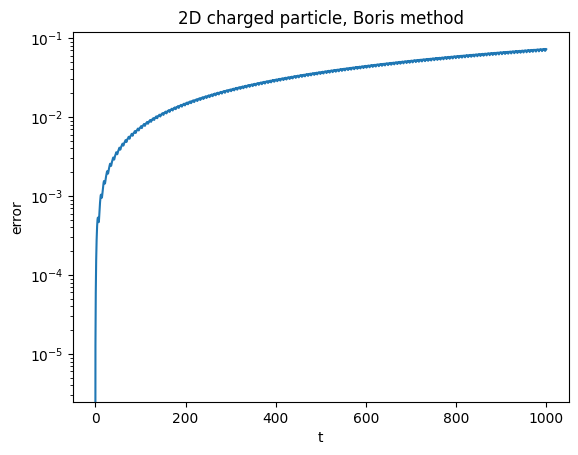

In [119]:
plot_error(boris_x_2D, particle_reference_soln, "2D charged particle, Boris method")

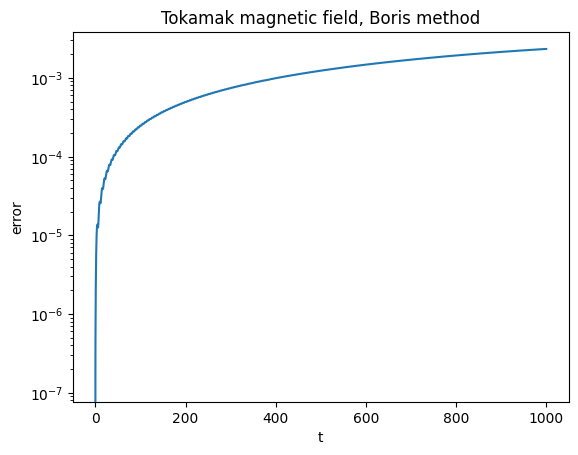

In [107]:
plot_error(boris_x_tok, tokamak_reference_soln, "Tokamak magnetic field, Boris method")

#### Runge-Kutta 4

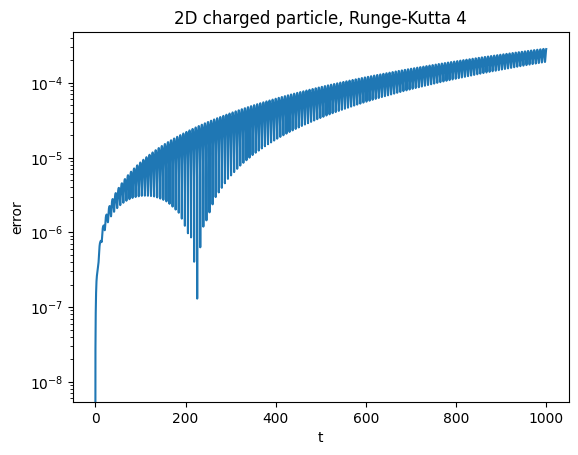

In [108]:
plot_error(rk4_x_2D, particle_reference_soln, "2D charged particle, Runge-Kutta 4")

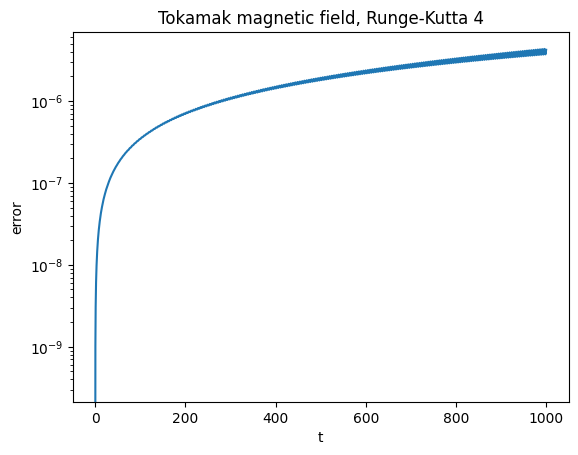

In [109]:
plot_error(rk4_x_tok, tokamak_reference_soln, "Tokamak magnetic field, Runge-Kutta 4")

#### Fourth-order symmetric multistep method

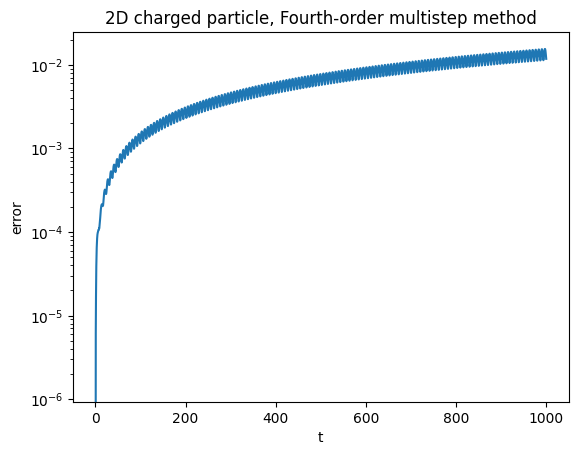

In [110]:
plot_error(multistep_x_2D, particle_reference_soln, "2D charged particle, Fourth-order multistep method")

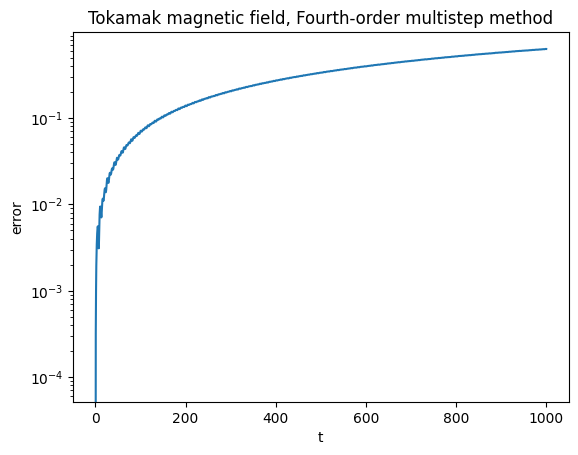

In [111]:
plot_error(multistep_x_tok, tokamak_reference_soln, "Tokamak magnetic field, Fourth-order multistep method")

We see from the error plots that Runge-Kutta 4 gives the lowest error rate for both systems.

## Energy plots

In [112]:
def E(x, v, U):
    U_vec = np.vectorize(U, signature='(d)->()')
    return 0.5 * np.linalg.norm(v, axis=-1) + U_vec(x)

def plot_energy(x, v, U, system, method):
    energies = E(x, v, U)
    energy_change = np.abs(energies - energies[0])

    plt.semilogy(energy_change)
    plt.xlabel("step (n)")
    plt.ylabel("energy change")
    plt.title(f"Energy change for {system} ({method})")
    plt.show()

### Boris method

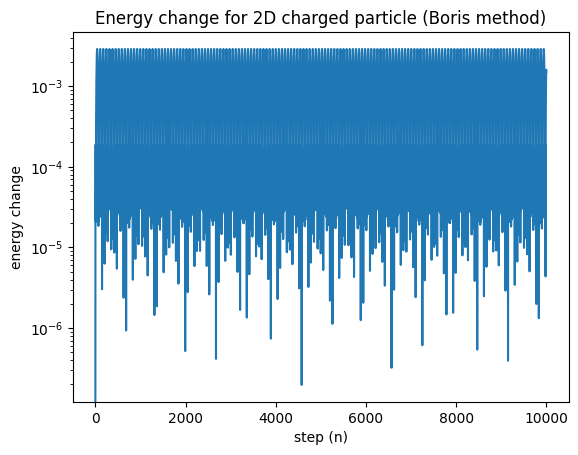

In [113]:
plot_energy(boris_x_2D, boris_v_2D, U_particle, "2D charged particle", "Boris method")

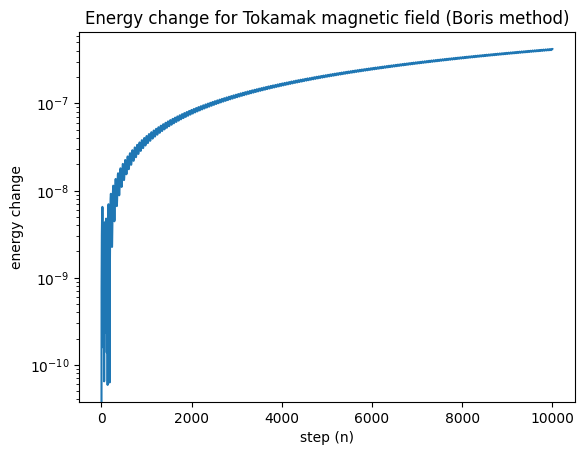

In [114]:
plot_energy(boris_x_tok, boris_v_tok, U_tokamak, "Tokamak magnetic field", "Boris method")

### Runge-Kutta 4

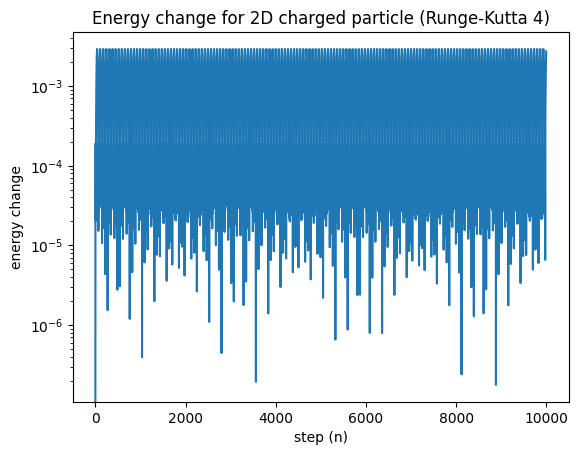

In [115]:
plot_energy(rk4_x_2D, rk4_v_2D, U_particle, "2D charged particle", "Runge-Kutta 4")

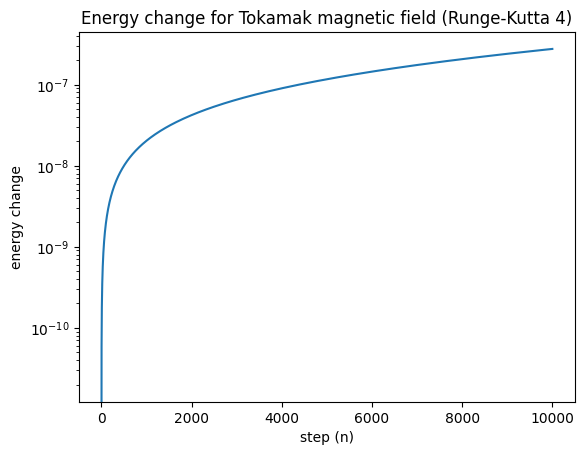

In [116]:
plot_energy(rk4_x_tok, rk4_v_tok, U_tokamak, "Tokamak magnetic field", "Runge-Kutta 4")

### Fourth-order symmetric multistep method

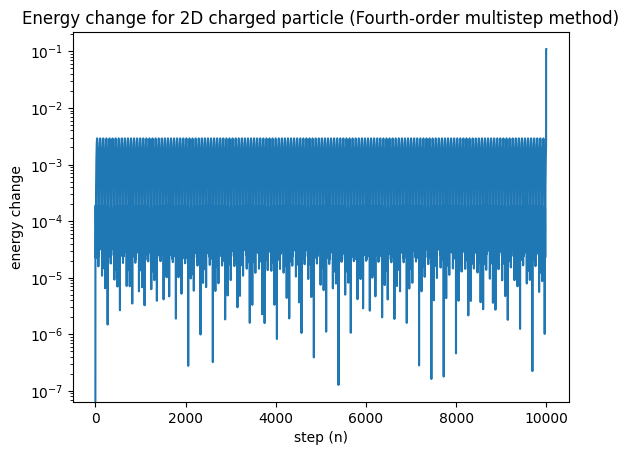

In [117]:
plot_energy(multistep_x_2D, multistep_v_2D, U_particle, "2D charged particle", "Fourth-order multistep method")

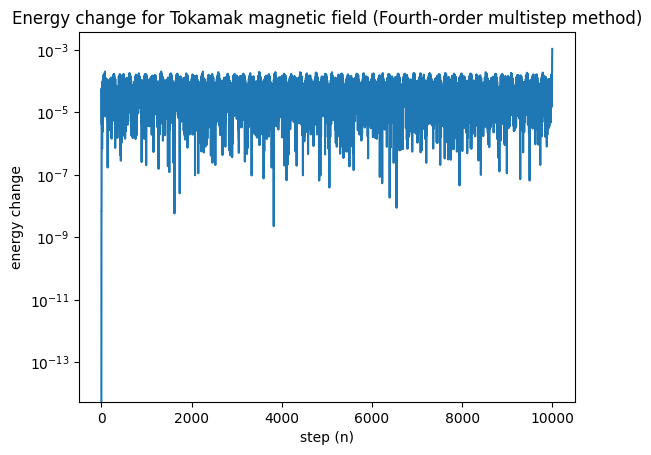

In [118]:
plot_energy(multistep_x_tok, multistep_v_tok, U_tokamak, "Tokamak magnetic field", "Fourth-order multistep method")